# Interpretability and Explainability

## Prepare model and data

In [1]:
import albumentations as A
from collections import defaultdict
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

from interpretability import *
from networks import *
from utils import *

In [2]:
IMAGE_DIR = '../data/ORIGA/Images_Cropped'
MASK_DIR = '../data/ORIGA/Masks_Cropped'
IMAGE_HEIGHT, IMAGE_WIDTH = 128, 128
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.pytorch.ToTensorV2(),
])

train_loader, val_loader, test_loader = load_origa(
    IMAGE_DIR, MASK_DIR, 0.7, 0.15, 0.15, test_transform, test_transform, test_transform, batch_size=4,
)

Loading ORIGA dataset:
    Train size: 454 (69.85%)
    Validation size: 98 (15.08%)
    Test size: 98 (15.08%)
    
    Image shape: (3, 128, 128)
    Mask shape: (128, 128)
    Batch size: 4

    Train loader length: 114
    Validation loader length: 25
    Test loader length: 25


In [3]:
model = Unet(in_channels=3, out_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)
checkpoint = torch.load('../checkpoints/best-multiclass-model.pth')
model.load_state_dict(checkpoint['model'])
model.eval()
model = model.to(DEVICE)

images, masks = next(iter(test_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)

print(model)

Unet(
  (encoder): Encoder(
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (conv2): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, ep

## Activation Visualization

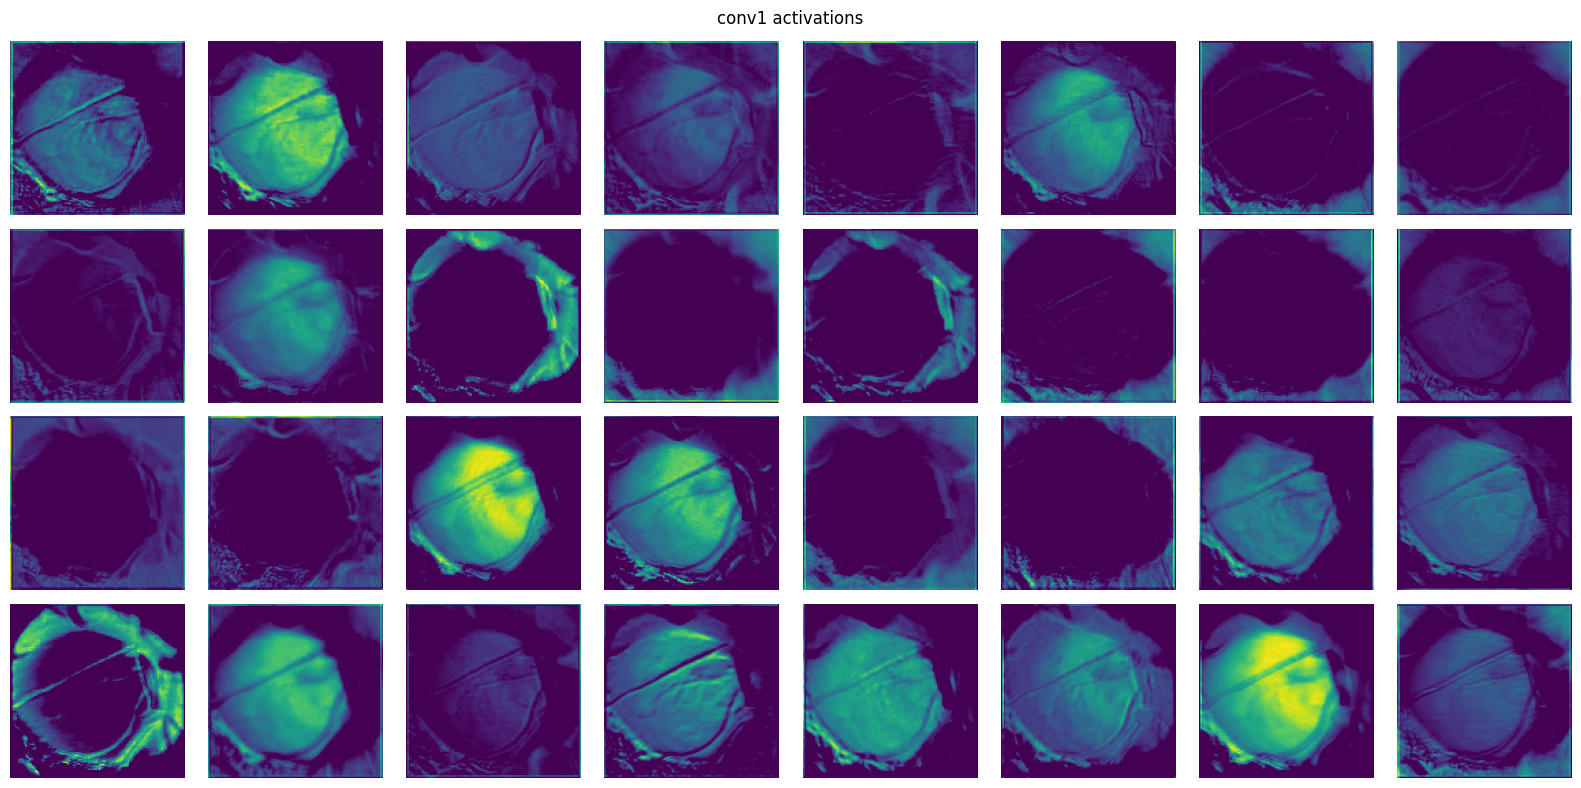

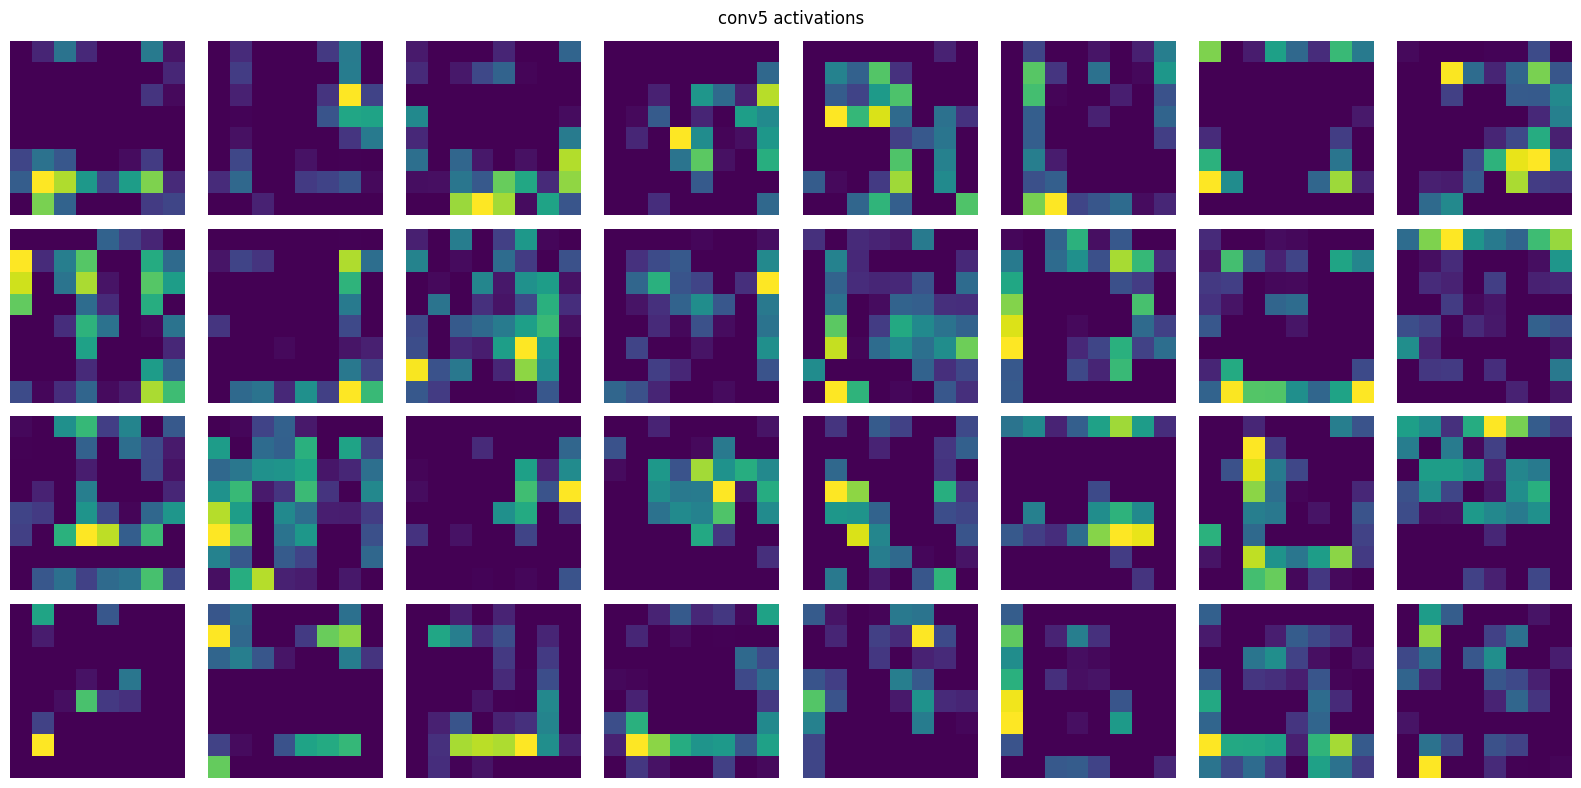

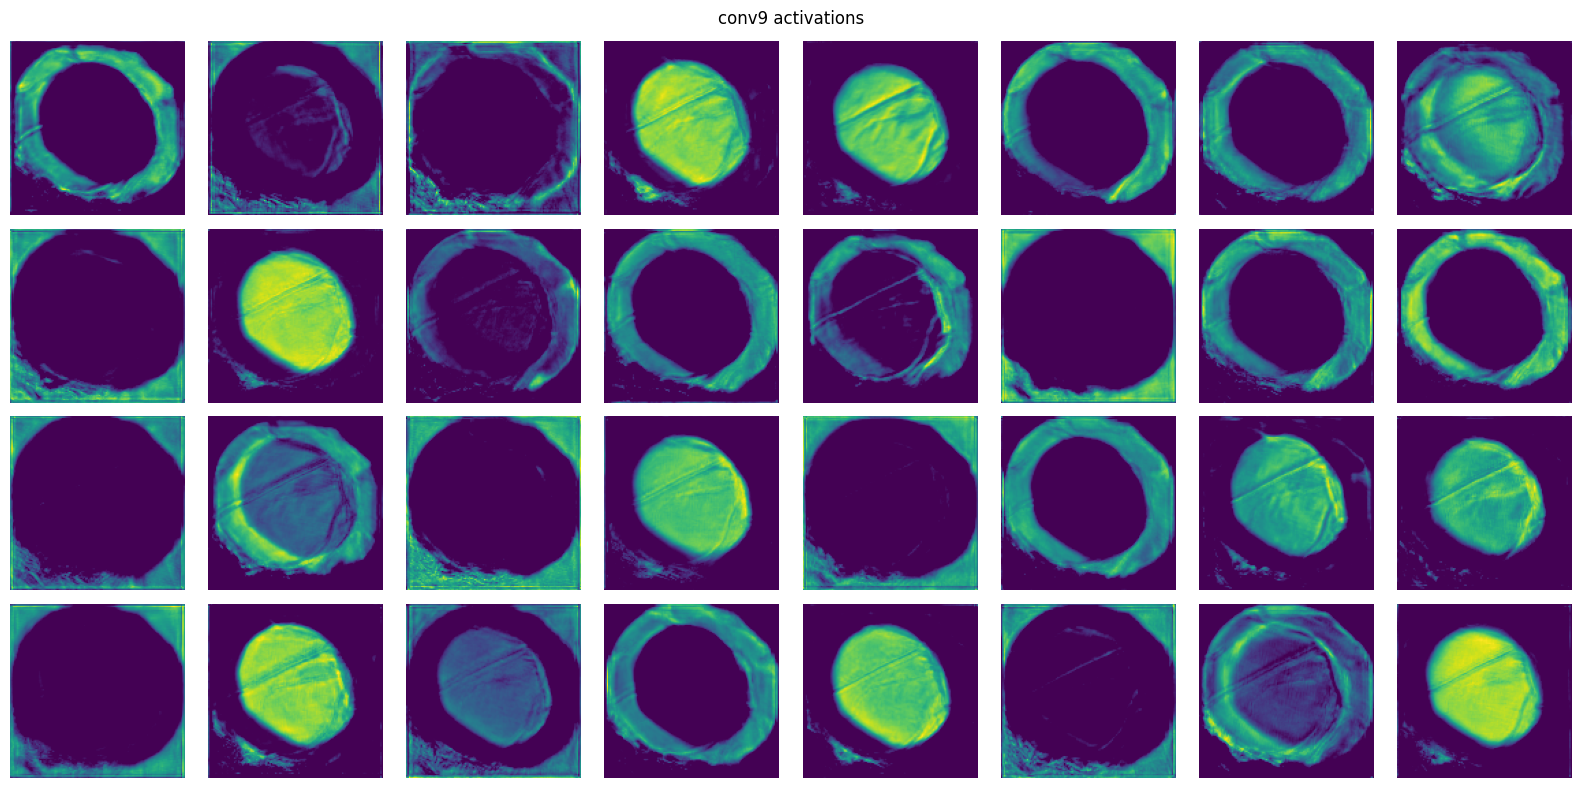

In [4]:
def get_activation(name):
    def hook(model, inputs, outputs):
        activation[name] = outputs.detach()

    return hook


activation = defaultdict(list)
model.encoder.conv1.register_forward_hook(get_activation('conv1'))
model.encoder.conv2.register_forward_hook(get_activation('conv2'))
model.encoder.conv3.register_forward_hook(get_activation('conv3'))
model.encoder.conv4.register_forward_hook(get_activation('conv4'))
model.encoder.conv5.register_forward_hook(get_activation('conv5'))
model.decoder.conv1.register_forward_hook(get_activation('conv6'))
model.decoder.conv2.register_forward_hook(get_activation('conv7'))
model.decoder.conv3.register_forward_hook(get_activation('conv8'))
model.decoder.conv4.register_forward_hook(get_activation('conv9'))
model.decoder.final.register_forward_hook(get_activation('conv10'))

with torch.no_grad():
    model(images)

# Plot conv1 activations
fig, ax = plt.subplots(4, 8, figsize=(16, 8))
plt.suptitle('conv1 activations')
ax = ax.ravel()
for i in range(32):
    ax[i].imshow(activation['conv1'][0][i].cpu().numpy())
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Plot conv5 activations
fig, ax = plt.subplots(4, 8, figsize=(16, 8))
plt.suptitle('conv5 activations')
ax = ax.ravel()
for i in range(32):
    ax[i].imshow(activation['conv5'][0][i].cpu().numpy())
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# Plot conv9 activations
fig, ax = plt.subplots(4, 8, figsize=(16, 8))
plt.suptitle('conv9 activations')
ax = ax.ravel()
for i in range(32):
    ax[i].imshow(activation['conv9'][0][i].cpu().numpy())
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Grad-CAM (Gradient-weighted Class Activation Mapping)

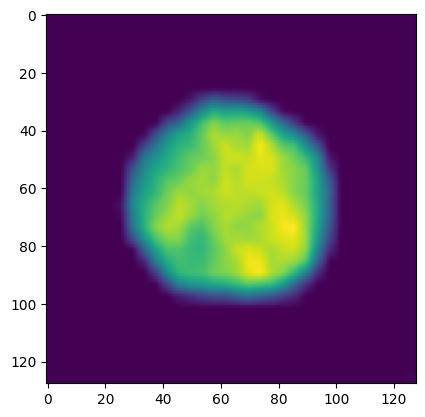

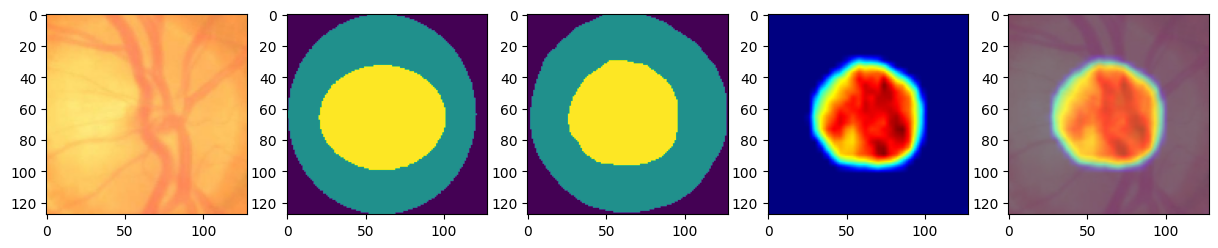

In [5]:
model_layers = dict(model.named_modules())
# print(model_layers.keys())
target_layer = model_layers['decoder.conv2.conv']

image = images[3:4]
mask = masks[3:4]

outputs = model(image)
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

gradcam = GradCAM(model, target_layer)
heatmap = gradcam(image, class_idx=2)
heatmap = heatmap.detach().cpu().numpy()
heatmap = cv.resize(heatmap, (IMAGE_WIDTH, IMAGE_HEIGHT))
heatmap = np.uint8(255 * heatmap / np.max(heatmap))

plt.imshow(heatmap)

image = image.squeeze().detach().cpu().numpy().transpose(1, 2, 0) / 255
mask = mask.squeeze().detach().cpu().numpy()
pred = preds.squeeze().detach().cpu().numpy()

overlay = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
overlay = cv.cvtColor(overlay, cv.COLOR_BGR2RGB) / 255

alpha = 0.5
combined = alpha * overlay + (1 - alpha) * image

_, ax = plt.subplots(1, 5, figsize=(15, 5))
ax[0].imshow(image)
ax[1].imshow(mask)
ax[2].imshow(pred)
ax[3].imshow(overlay)
ax[4].imshow(combined)
plt.show()

gradcam.unregister_hooks()

## Guided Backpropagation

## Guided Grad-CAM

## Occlusion Sensitivity

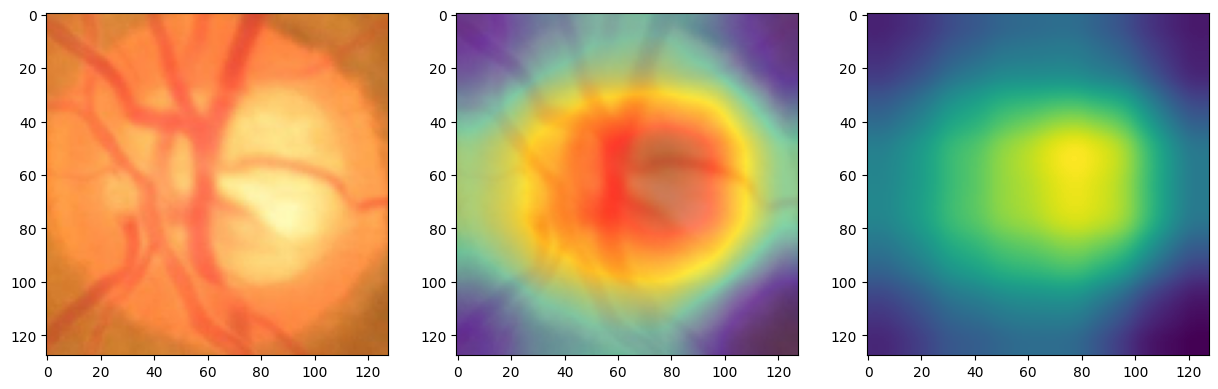

In [6]:
def occlusion_analysis(model, input_image, target_class, patch_size=32, stride=16):
    model.eval()
    image = input_image.clone()
    height, width = image.size(2), image.size(3)

    # Calculate the number of patches in both dimensions
    num_patches_h = (height - patch_size) // stride + 1
    num_patches_w = (width - patch_size) // stride + 1

    heatmap = torch.zeros((num_patches_h, num_patches_w), dtype=torch.float32)

    # Get the model's prediction without occlusion (baseline)
    with torch.no_grad():
        baseline_output = model(image)

    # Calculate the probability of the target class in the baseline output
    baseline_prob = F.softmax(baseline_output, dim=1)[0, target_class]

    # Iterate over each patch
    for i in range(num_patches_h):
        for j in range(num_patches_w):
            # Occlude the patch
            image[0, :, i * stride:i * stride + patch_size, j * stride:j * stride + patch_size] = 0.0

            # Get the model's prediction after occlusion
            with torch.no_grad():
                output = model(image)

            occluded_prob = F.softmax(output, dim=1)[0, target_class]

            # Update the heatmap with the confidence score
            diff = torch.abs(baseline_prob - occluded_prob)
            heatmap[i, j] = torch.mean(diff).item()

            # _, ax = plt.subplots(1, 3, figsize=(15, 5))
            # ax[0].imshow(image.squeeze().permute(1, 2, 0).cpu().numpy() / 255)
            # ax[1].imshow(occluded_prob.squeeze().cpu().numpy())
            # ax[2].imshow(heatmap.cpu().numpy())
            # plt.show()

            # Reset the occluded patch
            image[0, :, i * stride:i * stride + patch_size, j * stride:j * stride + patch_size] = \
                input_image[0, :, i * stride:i * stride + patch_size, j * stride:j * stride + patch_size].clone()

    # invert the heatmap values to obtain the saliency map
    # heatmap = torch.max(heatmap) - heatmap
    return heatmap


# Assuming you have loaded the trained model as 'model' and the input image as 'input_image'
# and 'target_class' is the class index for which you want to perform occlusion analysis
target_class = 2

# Convert the input image to a tensor and normalize it (assuming the image is in RGB format)
input_image = cv.imread(r"C:\Users\ASUS\PycharmProjects\DP-GlaucomaSegmentation\data\ORIGA\Images_Cropped\049.jpg")
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image = cv.resize(input_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
input_image = torch.tensor(input_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
input_image = input_image.to(DEVICE)

# Perform occlusion analysis for the target class
heatmap = occlusion_analysis(model, input_image, target_class)

# Upscale the heatmap to the original image size for visualization
upscale_factor_h = input_image.size(2) // heatmap.size(0)
upscale_factor_w = input_image.size(3) // heatmap.size(1)
heatmap_upscaled = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(input_image.size(2), input_image.size(3)),
                                 mode='bicubic', align_corners=False).squeeze().numpy()

# Normalize the heatmap values to the range [0, 255] for visualization
heatmap_upscaled = (heatmap_upscaled - heatmap_upscaled.min()) / (heatmap_upscaled.max() - heatmap_upscaled.min())
heatmap_upscaled = np.uint8(heatmap_upscaled * 255)

# Apply the heatmap as an overlay on the original image
overlayed_image = cv.applyColorMap(heatmap_upscaled, cv.COLORMAP_JET)
overlayed_image = cv.cvtColor(overlayed_image, cv.COLOR_BGR2RGB)

# Display the result
_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy() / 255)
ax[1].imshow(input_image.squeeze().permute(1, 2, 0).cpu().numpy() / 255)
ax[1].imshow(overlayed_image, alpha=0.5)
ax[2].imshow(heatmap_upscaled)
plt.show()


## Salience Maps

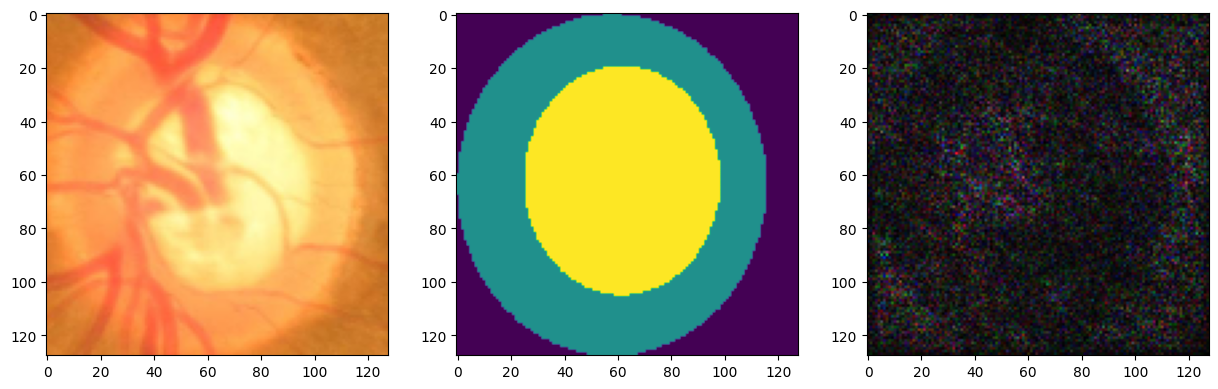

In [7]:
image = images[1:2]
mask = masks[1:2]

image.requires_grad = True
output = model(image)

output_scalar = output.sum()

model.zero_grad()
output_scalar.backward()

saliency_map = image.grad.abs().squeeze(0).cpu()
saliency_map = saliency_map / saliency_map.max()

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image.detach().squeeze(0).permute(1, 2, 0).cpu() / 255.0)
ax[1].imshow(mask.squeeze(0).cpu())
ax[2].imshow(saliency_map.permute(1, 2, 0))
plt.show()

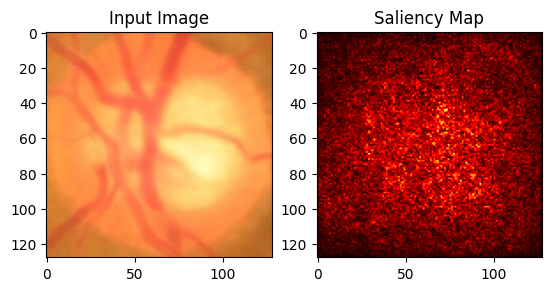

In [8]:
# Define the SaliencyMap class
class SaliencyMap:
    def __init__(self, model):
        self.model = model
        for param in self.model.parameters():
            param.requires_grad = False
        self.gradients = None
        self.register_hook()

    def register_hook(self):
        def hook_fn(module, grad_input, grad_output):
            self.gradients = grad_input[0]

        self.model.register_full_backward_hook(hook_fn)

    def generate(self, inputs, class_idx=None):
        self.model.zero_grad()

        inputs.requires_grad = True
        outputs = self.model(inputs)

        if class_idx is None:
            class_idx = torch.argmax(outputs, dim=1)

        onehot = torch.zeros(outputs.size(), dtype=torch.float32, device=inputs.device)
        onehot.scatter_(1, class_idx.unsqueeze(1), 1.0)

        outputs.backward(gradient=onehot, retain_graph=True)
        saliency_map = torch.abs(self.gradients[0]).max(dim=0)[0]

        return saliency_map


# Initialize SaliencyMap
saliency_map = SaliencyMap(model)

# Load an input image for visualization (replace 'path_to_input_image.jpg' with the path to your image)
input_image = cv.imread(r"C:\Users\ASUS\PycharmProjects\DP-GlaucomaSegmentation\data\ORIGA\Images_Cropped\049.jpg")
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)
input_image = cv.resize(input_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
input_image = torch.tensor(input_image, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
input_image = input_image.to(DEVICE)

# Compute the saliency map
saliency_map_output = saliency_map.generate(input_image)

# Normalize the saliency map for visualization
saliency_map_output = (saliency_map_output - saliency_map_output.min()) / (
        saliency_map_output.max() - saliency_map_output.min())
saliency_map_output = saliency_map_output.squeeze().detach().cpu().numpy()

# Display the original image and the saliency map
plt.subplot(1, 2, 1)
plt.imshow(input_image.detach().squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(saliency_map_output, cmap='hot')
plt.title('Saliency Map')

plt.show()


## Attention Maps

In [5]:
model = AttentionUnet(in_channels=3, out_channels=3, features=[32, 64, 128, 256, 512]).to(DEVICE)
checkpoint = torch.load('../checkpoints/best-attentionunet-multiclass-model.pth')
model.load_state_dict(checkpoint['model'])
model.eval()
model = model.to(DEVICE)

images, masks = next(iter(val_loader))
images = images.float().to(DEVICE)
masks = masks.long().to(DEVICE)
# print(model)

In [ ]:
def hook_fn(module, inputs, outputs):
    global attention_map
    attention_map = outputs.detach()

attention_map = None
model.decoder.ag4.psi.register_forward_hook(hook_fn)

with torch.no_grad():
    outputs = model(images)
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)

# Visualize the attention map
fig, ax = plt.subplots(4, 3, figsize=(12, 12))
ax = ax.ravel()
for i in range(4):
    ax[3 * i].imshow(images[i].cpu().numpy().transpose(1, 2, 0) / 255.0)
    ax[3 * i + 1].imshow(masks[i].cpu().numpy())
    ax[3 * i + 2].imshow(attention_map[i, 0].cpu().numpy())
plt.tight_layout()
plt.show()